# Predicción de preico vivienda en Madrid

## 0. Librerias

In [110]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import category_encoders as ce
import xgboost as xgb
import warnings

from sklearn.model_selection import train_test_split,RandomizedSearchCV,cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder,MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from category_encoders import TargetEncoder
from scipy.stats import randint, uniform
from xgboost import XGBRegressor


## 1. Lectura del Dataset

In [111]:
#Función para juntar dataframe 
def merge_and_clean_data(files, column_order, month):
    """
    Fusionar y limpiar múltiples archivos CSV añadiendo una columna de mes y eliminando duplicados.

    Parámetros:
    files (lista de str): Lista de rutas de archivo a los archivos CSV.
    column_order (lista de str): Lista de columnas para ordenar el DataFrame.
    months (lista de str): Lista de nombres de meses correspondientes a cada archivo.

    Retorna:
    pd.DataFrame: El DataFrame fusionado y limpio.
    """
    dfs = []

    for file, month in zip(files, months):
        df = pd.read_csv(file)
        df['month'] = month
        df = df[column_order]
        dfs.append(df)

    # Concatenar los DataFrames
    merged_df = pd.concat(dfs, ignore_index=True)

    # Eliminar filas duplicadas basadas en 'propertyCode', manteniendo la última ocurrencia
    merged_df = merged_df.drop_duplicates(subset='propertyCode', keep='last')

    return merged_df

# Uso de la función
path = 'C:/Users/nicol/OneDrive/Documentos/VSCLocal/Data/TFM/'
files = [path + "idealista_02.csv", path + "idealista_03.csv", path + "idealista_04.csv", path + "idealista_05.csv"]
months = ['Febrero', 'Marzo', 'Abril', 'Mayo']

column_order = ['index', 'propertyCode', 'thumbnail', 'externalReference', 'numPhotos','floor', 'price', 'propertyType', 'operation', 'size', 'exterior','rooms',
                'bathrooms', 'address', 'province', 'municipality', 'district','country', 'neighborhood', 'latitude', 'longitude', 'showAddress','url', 'distance',
                'description', 'hasVideo', 'status','newDevelopment', 'hasLift', 'priceByArea', 'detailedType','suggestedTexts', 'hasPlan', 'has3DTour', 'has360',
                'hasStaging','topNewDevelopment', 'topPlus', 'highlight', 'parkingSpace','newDevelopmentFinished','month']


merged_df = merge_and_clean_data(files, column_order, months)

# Mostrar el tamaño del DataFrame fusionado
print(merged_df.shape)

(14993, 42)


In [112]:
merged_df['municipality'].value_counts()

municipality
Madrid                14551
Pozuelo de Alarcón      351
Leganés                  89
Getafe                    2
Name: count, dtype: int64

In [113]:
df = merged_df[(merged_df['municipality']=='Madrid') & (merged_df['price']<=800000)]
df['municipality'].value_counts()

municipality
Madrid    10567
Name: count, dtype: int64

In [114]:
columna_a_borrar= ["index","has360","thumbnail","externalReference","numPhotos","operation","hasStaging","topPlus",
                    "showAddress","url","description","suggestedTexts","has3DTour","topNewDevelopment","priceByArea","month",
                    "newDevelopmentFinished","newDevelopment","detailedType","hasPlan",'address','hasVideo','highlight','country','parkingSpace','province','municipality']
df=df.drop(columna_a_borrar,axis=1)
df.isna().sum()

propertyCode      0
floor           576
price             0
propertyType      0
size              0
exterior        714
rooms             0
bathrooms         0
district          0
neighborhood      0
latitude          0
longitude         0
distance          0
status            0
hasLift         163
dtype: int64

In [115]:
# Agregar precio por barrio al DataFrame
df_precios_barrios=pd.read_excel(path+"precios madrid.xlsx","precio_barrios")
df_precios_barrios=df_precios_barrios[['Barrio','Precio m2 mayo 2024']]
df_precios_barrios

,Barrio,Precio m2 mayo 2024
0,Acacias,4627
1,Chopera,4364
2,Delicias,4500
3,Legazpi,4961
4,Palos de Moguer,4902
...,...,...
128,Palos de la Frontera,4500
129,Pavones,3077
130,Villaverde Alto,2125
131,Virgen del Cortijo - Manoteras,3530


In [116]:
# Corrige el nombre en la columna 'neighborhood'
df['neighborhood'] = df['neighborhood'].replace('Valdebernardo - Valderrivas', 'Valdebernardo - Valderribas')

# Realiza el merge
merged_df = pd.merge(df, df_precios_barrios, how='left', left_on='neighborhood', right_on='Barrio')

# Renombra la nueva columna
merged_df.rename(columns={'Precio m2 mayo 2024': 'priceByAreaByNeighborhood'}, inplace=True)  # Reemplaza 'price_column_name' con el nombre real de la columna de precios

# Verifica si hubo algún desajuste
dismatches = merged_df[merged_df['priceByAreaByNeighborhood'].isnull()]

# Muestra los desajustes
print("Desajustes encontrados:")
print(dismatches)

# Muestra los primeros registros del DataFrame fusionado
print("DataFrame fusionado:")
merged_df.drop(columns='Barrio',inplace=True)
print(merged_df.info())

Desajustes encontrados:
Empty DataFrame
Columns: [propertyCode, floor, price, propertyType, size, exterior, rooms, bathrooms, district, neighborhood, latitude, longitude, distance, status, hasLift, Barrio, priceByAreaByNeighborhood]
Index: []
DataFrame fusionado:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10567 entries, 0 to 10566
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   propertyCode               10567 non-null  int64  
 1   floor                      9991 non-null   object 
 2   price                      10567 non-null  float64
 3   propertyType               10567 non-null  object 
 4   size                       10567 non-null  float64
 5   exterior                   9853 non-null   object 
 6   rooms                      10567 non-null  int64  
 7   bathrooms                  10567 non-null  int64  
 8   district                   10567 non-null  object 
 9   neighb

In [117]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer

df=merged_df

# Filtrar los valores 'st' y cuyo neighborhood estén vacios y baaños sean 0
df = df[df['floor'] != 'st']
df = df[pd.notna(df['neighborhood'])]
df = df[df['bathrooms'] != 0]
df = df[df['bathrooms'] <= 5]
df = df[df['floor'] != 60]

# Crear un diccionario de mapeo para los valores categóricos
mapping = {'bj': 0,'ss': -1,'en': 0,np.nan: np.nan}

# Aplicar el mapeo y convertir los valores a numéricos
df['floor'] = df['floor'].map(mapping).fillna(df['floor'])
df['floor'] = pd.to_numeric(df['floor'], errors='coerce')

# Usar SimpleImputer para imputar los valores faltantes con la mediana
imputer_mediana = SimpleImputer(strategy='median')
df['floor'] = imputer_mediana.fit_transform(df[['floor']])

# Convertir la columna 'floor' a tipo int64
df['floor'] = df['floor'].astype('int64')

# Usar SimpleImputer para imputar los valores faltantes con el valor más frecuente (la moda)
imputer_moda = SimpleImputer(strategy='most_frequent')
df['exterior'] = imputer_moda.fit_transform(df[['exterior']]).ravel()
df['hasLift'] = imputer_moda.fit_transform(df[['hasLift']]).ravel()

# Reemplazar 'True' por '1' y 'False' por '0' en la columna 'exterior'
df['exterior'] = df['exterior'].replace('True', 1)
df['exterior'] = df['exterior'].replace('False', 0)
df['exterior'] = df['exterior'].astype(int)

# Reemplazar 'True' por '1' y 'False' por '0' en la columna 'hasLift'
df['hasLift'] = df['hasLift'].replace('True', 1)
df['hasLift'] = df['hasLift'].replace('False', 0)
df['hasLift'] = df['hasLift'].astype(int)

# Comprobar valores faltantes después de la imputación
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 10515 entries, 0 to 10566
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   propertyCode               10515 non-null  int64  
 1   floor                      10515 non-null  int64  
 2   price                      10515 non-null  float64
 3   propertyType               10515 non-null  object 
 4   size                       10515 non-null  float64
 5   exterior                   10515 non-null  int32  
 6   rooms                      10515 non-null  int64  
 7   bathrooms                  10515 non-null  int64  
 8   district                   10515 non-null  object 
 9   neighborhood               10515 non-null  object 
 10  latitude                   10515 non-null  float64
 11  longitude                  10515 non-null  float64
 12  distance                   10515 non-null  int64  
 13  status                     10515 non-null  object 


In [118]:
df['district'].value_counts()

district
Centro                 1661
Carabanchel             820
Barrio de Salamanca     819
Tetuán                  735
Ciudad Lineal           701
Puente de Vallecas      666
Arganzuela              650
Latina                  458
Chamberí                456
Villaverde              436
Hortaleza               434
San Blas                431
Fuencarral              382
Retiro                  381
Usera                   350
Chamartín               342
Moncloa                 295
Villa de Vallecas       225
Moratalaz               138
Vicálvaro               129
Barajas                   6
Name: count, dtype: int64

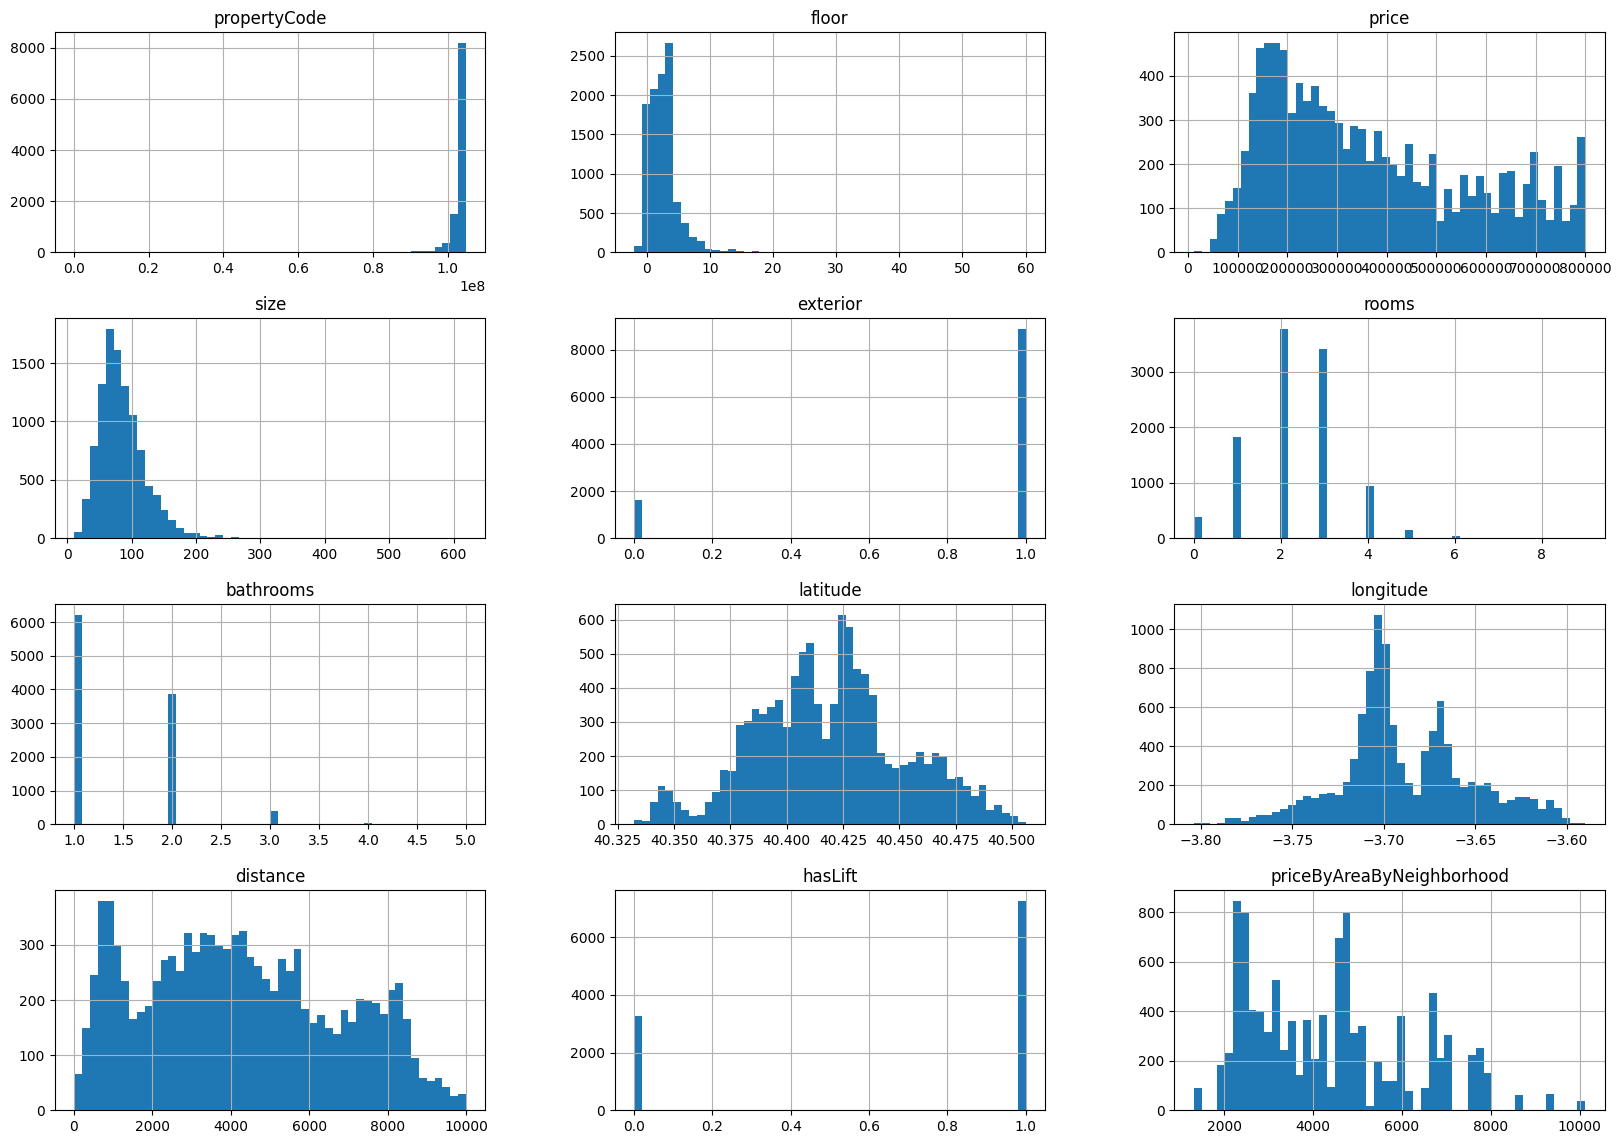

In [119]:
df.hist(bins=50, figsize=(20, 14))
plt.show()

In [120]:
numeric_df = df.select_dtypes(include=['number'])
numeric_df.corr()['price'].sort_values(ascending=False)

price                        1.000000
priceByAreaByNeighborhood    0.640912
bathrooms                    0.590895
size                         0.576899
hasLift                      0.441460
latitude                     0.385770
rooms                        0.263182
floor                        0.197049
exterior                    -0.014839
propertyCode                -0.036713
longitude                   -0.036882
distance                    -0.303303
Name: price, dtype: float64

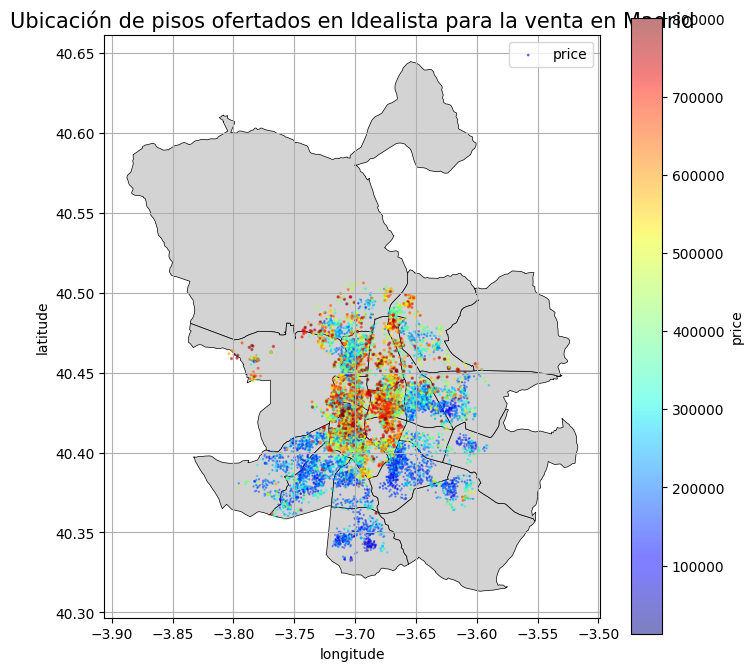

In [121]:
import pandas as pd
import geopandas as gpd

path="C:/Users/nicol/OneDrive/Documentos/VSCLocal/Data/TFM/"
madrid_districts = gpd.read_file(path+"madrid_districts.geojson")
fig, ax = plt.subplots(figsize=(8, 8))


madrid_districts.plot(ax=ax, color='lightgray', edgecolor='black', alpha=1, linewidth=0.5)



df.plot(kind="scatter", x="longitude", y="latitude", grid=True,
            s=df["price"] / 400000, label="price",
            c="price", cmap="jet", colorbar=True,
            legend=True, sharex=False, ax=ax,alpha=0.5)
ax.set_title("Ubicación de pisos ofertados en Idealista para la venta en Madrid", fontsize=15)
ax.legend()


plt.show()

In [122]:
def feature_engineering(df):
    """
    Calcula las columnas adicionales 'roomSize', 'bathroomSize', 'bathroomRoom' y 'liftFloorInteraction'.
    
    :param df: DataFrame que contiene las columnas 'size', 'rooms', 'bathrooms', 'hasLift', 'floor' y 'propertyType'.
    :return: DataFrame con las nuevas columnas calculadas.
    """
    # Inicializar las nuevas columnas
    df['roomSize'] = 0.0
    df['bathroomSize'] = 0.0
    df['bathroomRoom'] = 0.0
    df['liftFloorInteraction'] = 0

    # Calcular 'roomSize'
    mask_rooms_nonzero = df['rooms'] != 0
    df.loc[mask_rooms_nonzero, 'roomSize'] = (df.loc[mask_rooms_nonzero, 'size'] / df.loc[mask_rooms_nonzero, 'rooms']).astype(float)
    
    # Calcular 'bathroomSize'
    mask_bathrooms_nonzero = df['bathrooms'] != 0
    df.loc[mask_bathrooms_nonzero, 'bathroomSize'] = (df.loc[mask_bathrooms_nonzero, 'size'] / df.loc[mask_bathrooms_nonzero, 'bathrooms']).astype(float)
    
    # Calcular 'bathroomRoom'
    df.loc[mask_rooms_nonzero, 'bathroomRoom'] = (df.loc[mask_rooms_nonzero, 'bathrooms'] / df.loc[mask_rooms_nonzero, 'rooms']).astype(float)
    
    # Calcular 'liftFloorInteraction'
    df['liftFloorInteraction'] = df['hasLift'] * df['floor']
    
    # Ajustar 'roomSize' y 'bathroomRoom' para 'studio' con 'rooms' == 0
    mask_studio_no_rooms = (df['propertyType'] == 'studio') & (df['rooms'] == 0)
    df.loc[mask_studio_no_rooms, 'roomSize'] = 0
    df.loc[mask_studio_no_rooms, 'bathroomRoom'] = 0
        
    return df


feature_engineering_df=feature_engineering(df.copy())




In [123]:
feature_engineering_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10515 entries, 0 to 10566
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   propertyCode               10515 non-null  int64  
 1   floor                      10515 non-null  int64  
 2   price                      10515 non-null  float64
 3   propertyType               10515 non-null  object 
 4   size                       10515 non-null  float64
 5   exterior                   10515 non-null  int32  
 6   rooms                      10515 non-null  int64  
 7   bathrooms                  10515 non-null  int64  
 8   district                   10515 non-null  object 
 9   neighborhood               10515 non-null  object 
 10  latitude                   10515 non-null  float64
 11  longitude                  10515 non-null  float64
 12  distance                   10515 non-null  int64  
 13  status                     10515 non-null  object 


In [124]:
numeric_df = feature_engineering_df.select_dtypes(include=['number'])

numeric_df.corr()['price'].sort_values(ascending=False)

price                        1.000000
priceByAreaByNeighborhood    0.640912
bathrooms                    0.590895
size                         0.576899
hasLift                      0.441460
latitude                     0.385770
roomSize                     0.330561
liftFloorInteraction         0.322382
bathroomRoom                 0.280138
rooms                        0.263182
floor                        0.197049
bathroomSize                 0.082567
exterior                    -0.014839
propertyCode                -0.036713
longitude                   -0.036882
distance                    -0.303303
Name: price, dtype: float64

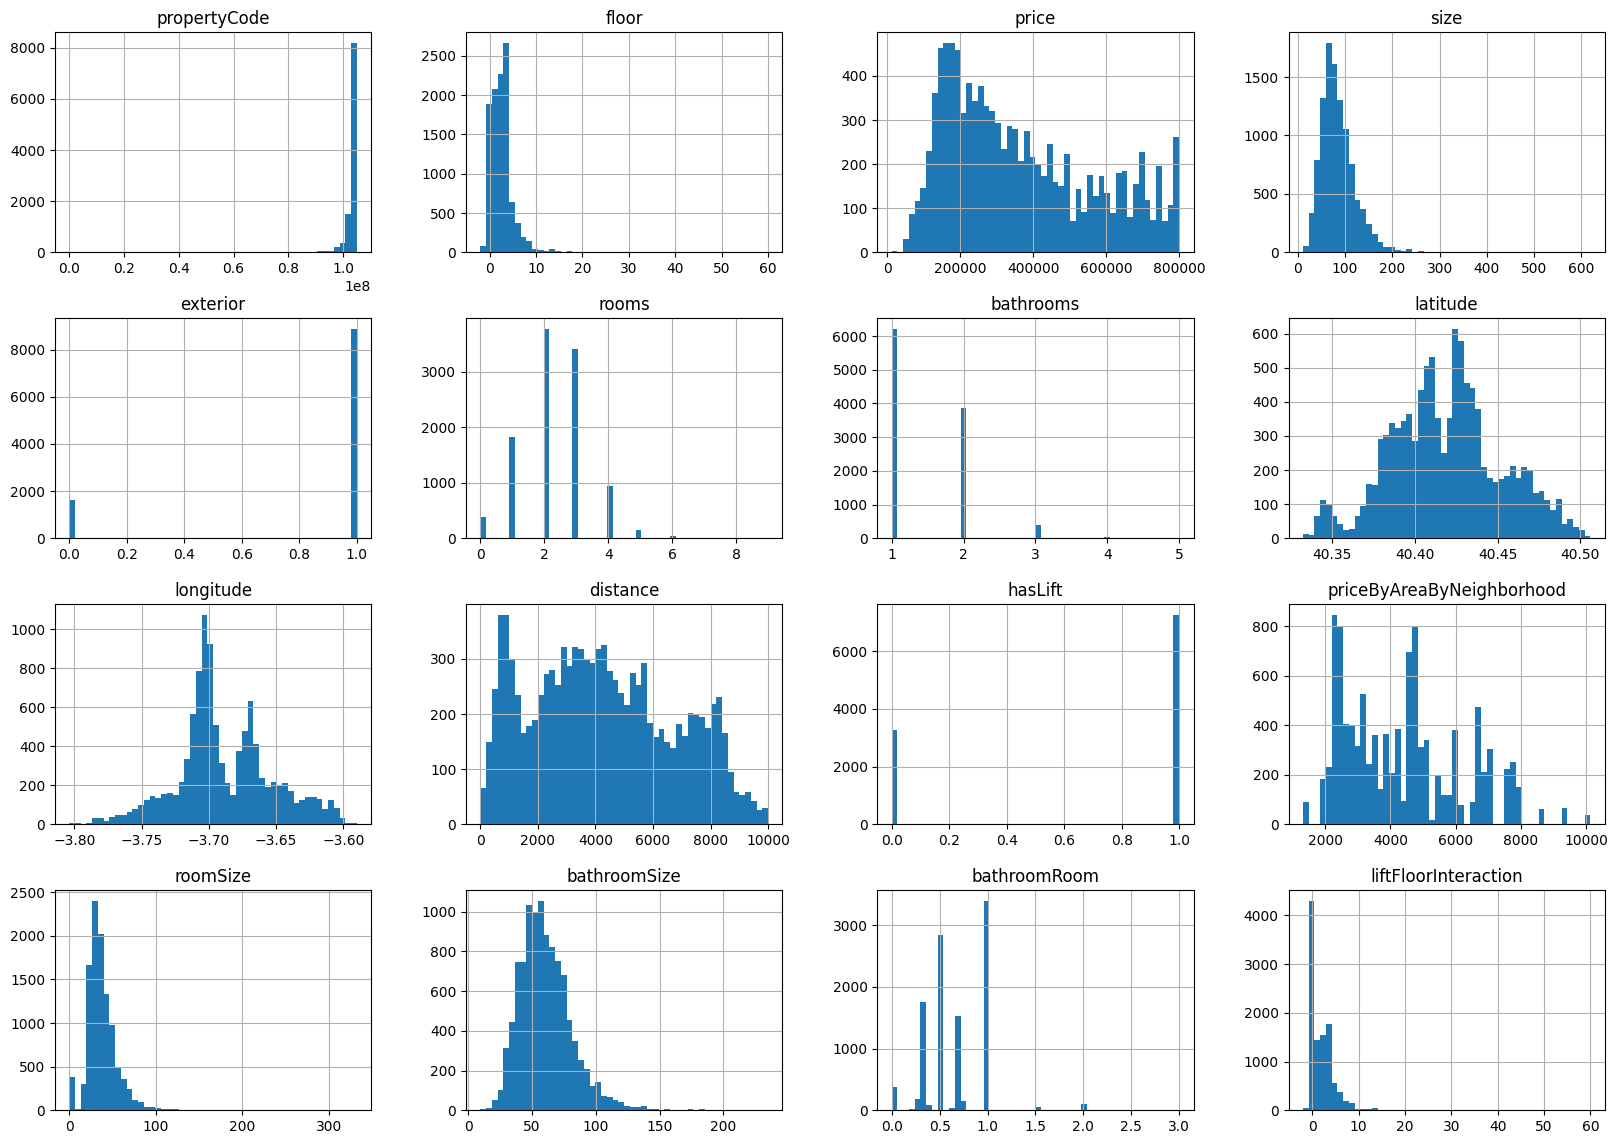

In [125]:
feature_engineering_df.hist(bins=50, figsize=(20, 14))
plt.show()

In [126]:
feature_engineering_df['neighborhood'].value_counts()

neighborhood
Lavapiés-Embajadores         494
Malasaña-Universidad         434
Goya                         253
Palacio                      234
Pueblo Nuevo                 218
                            ... 
Valdebebas - Valdefuentes      8
Montecarmelo                   8
Alameda de Osuna               6
El Plantío                     2
Los Berrocales                 1
Name: count, Length: 131, dtype: int64

In [127]:
# Cargar los datos
data = feature_engineering_df

# Separar las características y la variable objetivo
X = data.drop(columns=['price','propertyCode'])
y = data['price']

# Identificar columnas categóricas y numéricas
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

# Crear preprocesadores para columnas numéricas y categóricas
numeric_transformer = StandardScaler()
categorical_transformer = TargetEncoder()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Crear el pipeline con preprocesador y modelo
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', LinearRegression())])

# Dividir el conjunto de datos asegurando la estratificación por 'neighborhood'
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=X['district'], random_state=42)

# Entrenar el modelo y evaluar su rendimiento utilizando validación cruzada
rmse_scores = -cross_val_score(model, X_train, y_train, cv=10, scoring='neg_root_mean_squared_error')

# Resultados
print("RSME Scores: ", rmse_scores)
print("Mean RSME: ", rmse_scores.mean())


RSME Scores:  [86466.72647076 88560.75637337 88105.29794927 87386.36758036
 85499.20717885 86721.45718044 86020.66794284 87910.16955161
 90709.58100668 84975.288185  ]
Mean RSME:  87235.55194191707


In [128]:
# Cargar los datos
data = feature_engineering_df

# Separar las características y la variable objetivo
X = data.drop(columns=['price','propertyCode'])
y = data['price']

# Identificar columnas categóricas y numéricas
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

# Crear preprocesadores para columnas numéricas y categóricas
numeric_transformer = StandardScaler()
categorical_transformer = TargetEncoder()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Crear el pipeline con preprocesador y modelo
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', RandomForestRegressor())])

# Dividir el conjunto de datos asegurando la estratificación por 'neighborhood'
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=X['district'], random_state=42)

# Entrenar el modelo y evaluar su rendimiento utilizando validación cruzada
rmse_scores = -cross_val_score(model, X_train, y_train, cv=10, scoring='neg_root_mean_squared_error')

# Resultados
print("RSME Scores: ", rmse_scores)
print("Mean RSME: ", rmse_scores.mean())

RSME Scores:  [64454.08601893 68409.78940125 64699.83714426 69007.23024288
 68633.95711949 64179.74889612 62388.44275373 64949.6231655
 63501.00391533 61957.36187144]
Mean RSME:  65218.10805289364


In [129]:
# Cargar los datos
data = feature_engineering_df

# Separar las características y la variable objetivo
X = data.drop(columns=['price','propertyCode'])
y = data['price']

# Identificar columnas categóricas y numéricas
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

# Crear preprocesadores para columnas numéricas y categóricas
numeric_transformer = StandardScaler()
categorical_transformer = TargetEncoder()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Crear el pipeline con preprocesador y modelo
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', GradientBoostingRegressor())])

# Dividir el conjunto de datos asegurando la estratificación por 'neighborhood'
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=X['district'], random_state=42)

# Entrenar el modelo y evaluar su rendimiento utilizando validación cruzada
rmse_scores = -cross_val_score(model, X_train, y_train, cv=10, scoring='neg_root_mean_squared_error')

# Resultados
print("RSME Scores: ", rmse_scores)
print("Mean RSME: ", rmse_scores.mean())

RSME Scores:  [72593.35304963 72594.77953251 71696.83521456 74801.2555549
 71991.66131493 71612.01555425 69834.83036531 72423.1066299
 71902.99656862 67537.26718508]
Mean RSME:  71698.81009696829


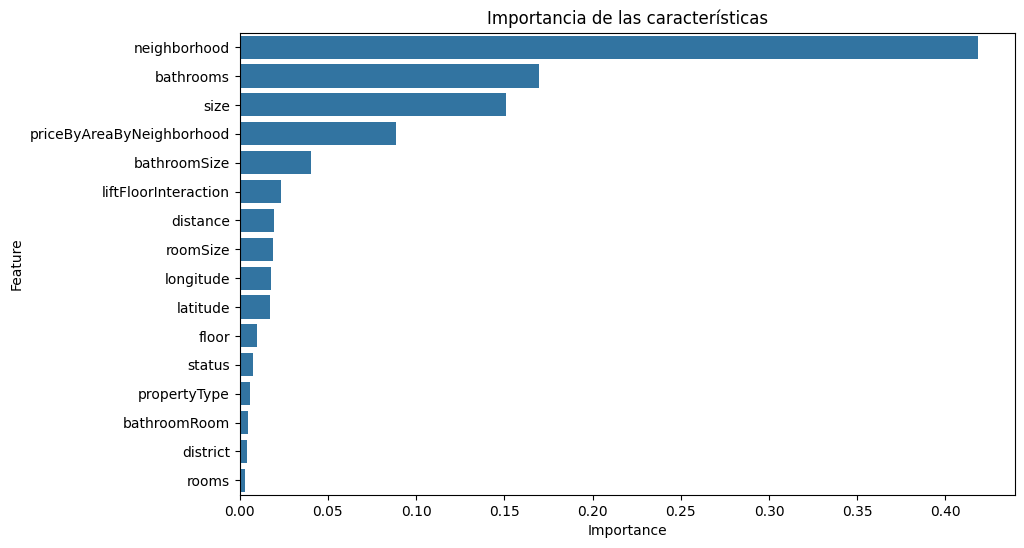

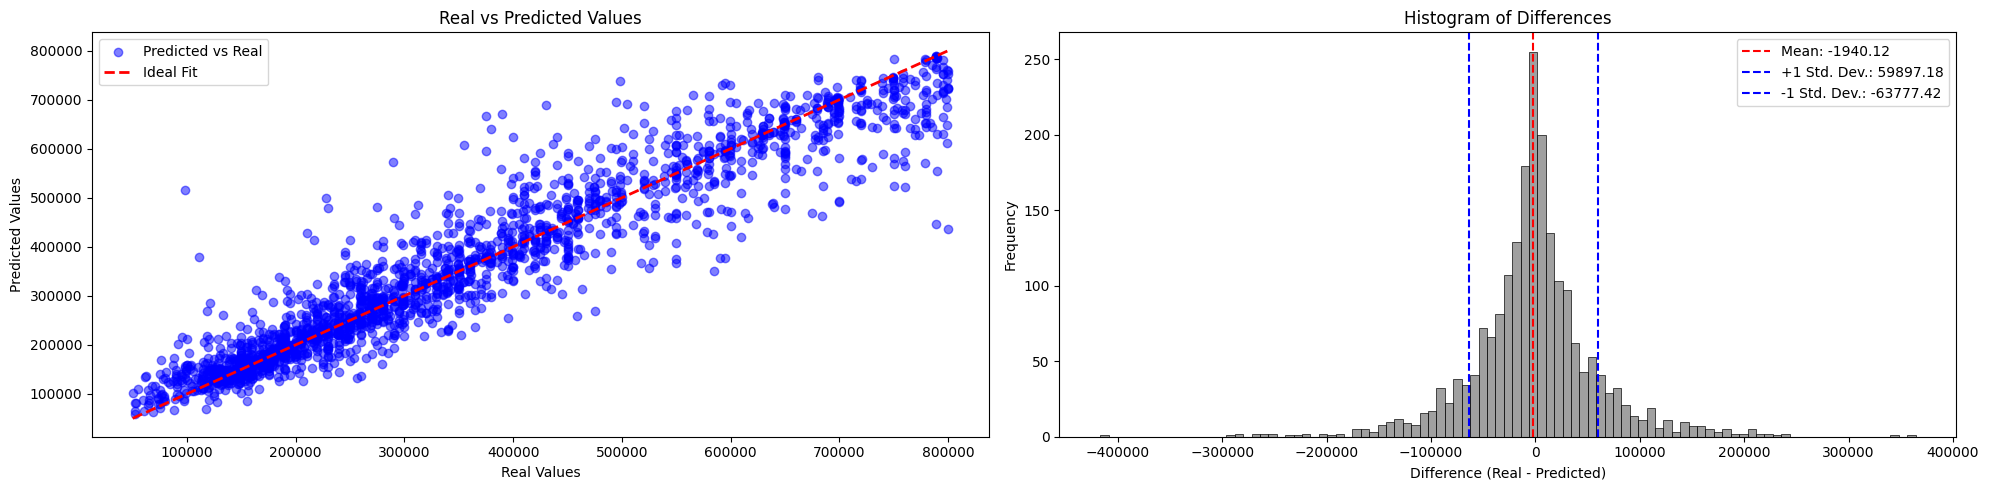

Best parameters found:  {'regressor__max_depth': 20, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 300}
RSME on test set:  61853.03021571403


In [130]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from category_encoders import TargetEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error

# Supongamos que los datos están en un DataFrame llamado 'feature_engineering_df'
data = feature_engineering_df

# Separar las características y la variable objetivo
X = data.drop(columns=['price','propertyCode'])
y = data['price']

# Identificar columnas categóricas y numéricas
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

# Crear preprocesadores para columnas numéricas y categóricas
numeric_transformer = StandardScaler()
categorical_transformer = TargetEncoder()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Crear el pipeline con preprocesador y modelo de Random Forest
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', RandomForestRegressor(random_state=42))])

# Dividir el conjunto de datos asegurando la estratificación por 'district'
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=X['district'], random_state=42)

# Definir los parámetros para la búsqueda
param_grid = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4]
}

# Realizar GridSearchCV para optimizar hiperparámetros
grid_search = GridSearchCV(model, param_grid, cv=10, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Mejor modelo encontrado por GridSearchCV
best_model = grid_search.best_estimator_

# Evaluar el modelo en el conjunto de prueba
y_pred = best_model.predict(X_test)

# Calcular RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Importancia de las características
feature_importances = best_model.named_steps['regressor'].feature_importances_
features = np.append(numerical_cols, categorical_cols)
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances}).sort_values(by='Importance', ascending=False)

# Gráfico de importancia de características
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Importancia de las características')
plt.show()

# Gráfico de diferencias entre valores predichos y reales
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.5, color='blue', label='Predicted vs Real')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Ideal Fit')
plt.xlabel('Real Values')
plt.ylabel('Predicted Values')
plt.title('Real vs Predicted Values')
plt.legend()

# Histograma de diferencias
differences = y_test - y_pred
plt.subplot(1, 2, 2)
sns.histplot(differences, kde=False, color='gray')
plt.axvline(differences.mean(), color='r', linestyle='--', label=f'Mean: {differences.mean():.2f}')
plt.axvline(differences.mean() + differences.std(), color='b', linestyle='--', label=f'+1 Std. Dev.: {differences.mean() + differences.std():.2f}')
plt.axvline(differences.mean() - differences.std(), color='b', linestyle='--', label=f'-1 Std. Dev.: {differences.mean() - differences.std():.2f}')
plt.xlabel('Difference (Real - Predicted)')
plt.ylabel('Frequency')
plt.title('Histogram of Differences')
plt.legend()

plt.tight_layout()
plt.show()

# Resultados
print("Best parameters found: ", grid_search.best_params_)
print("RSME on test set: ", rmse)


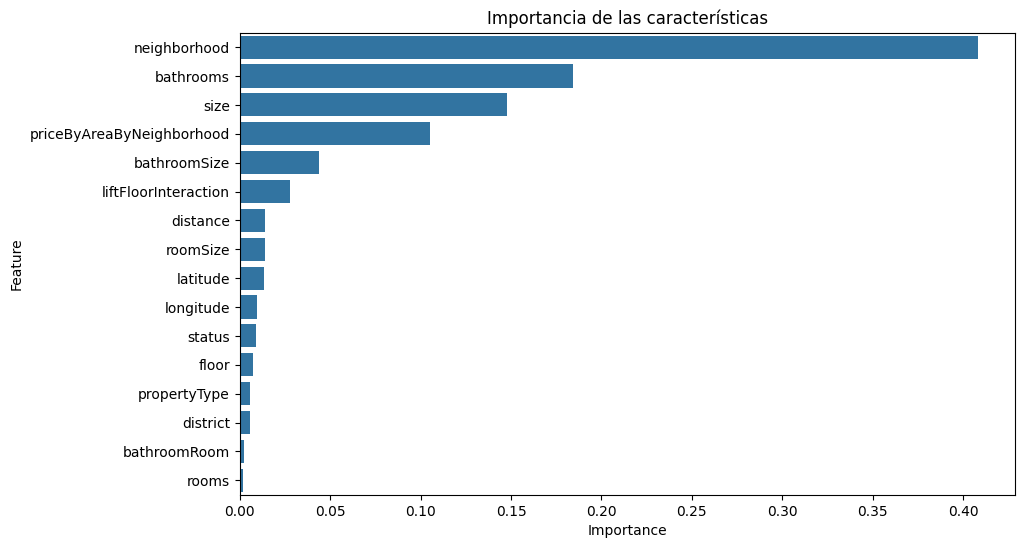

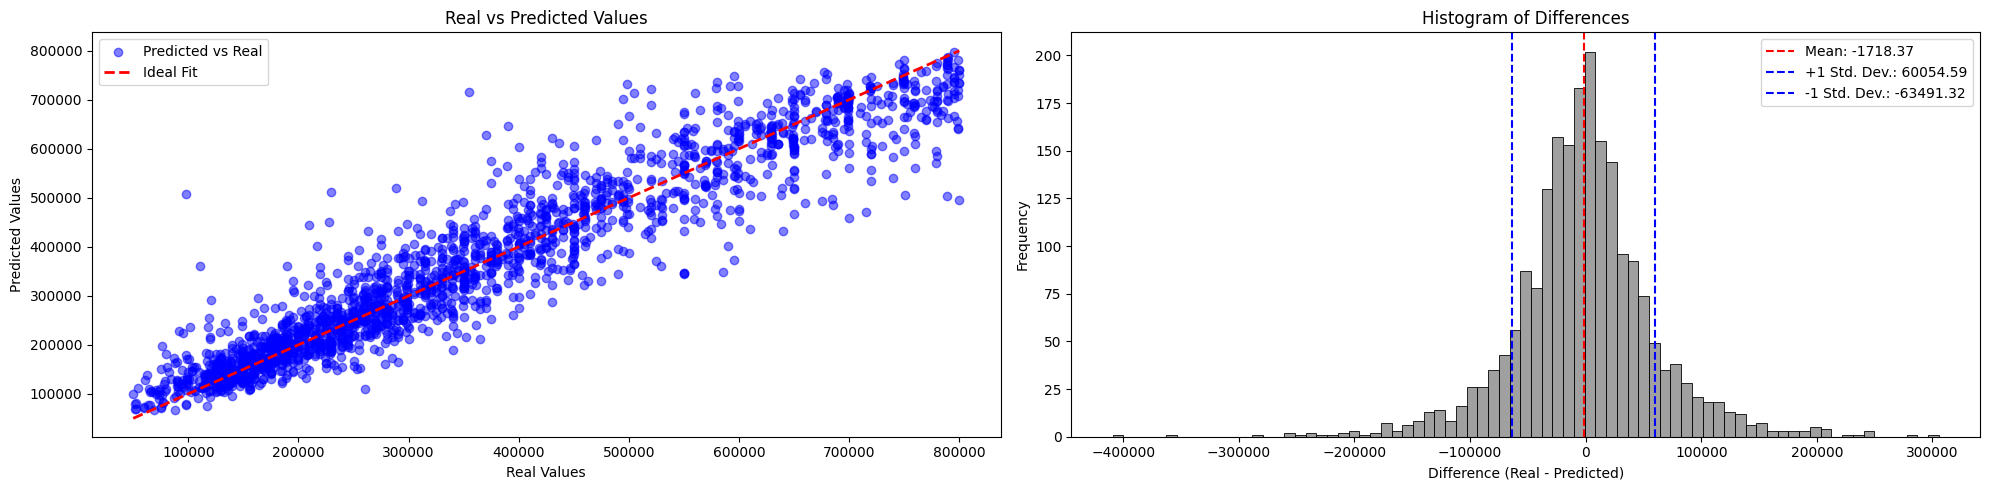

Best parameters found:  {'regressor__learning_rate': 0.1, 'regressor__max_depth': 5, 'regressor__n_estimators': 300}
RSME on test set:  61782.16419116136


In [131]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from category_encoders import TargetEncoder
import matplotlib.pyplot as plt
import seaborn as sns

# Supongamos que los datos están en un DataFrame llamado 'feature_engineering_df'
data = feature_engineering_df

# Separar las características y la variable objetivo
X = data.drop(columns=['price','propertyCode'])
y = data['price']

# Identificar columnas categóricas y numéricas
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

# Crear preprocesadores para columnas numéricas y categóricas
numeric_transformer = StandardScaler()
categorical_transformer = TargetEncoder()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Crear el pipeline con preprocesador y modelo de Gradient Boosting
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', GradientBoostingRegressor(random_state=42))])

# Dividir el conjunto de datos asegurando la estratificación por 'district'
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=X['district'], random_state=42)

# Definir los parámetros para la búsqueda
param_grid = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__learning_rate': [0.01, 0.1, 0.2],
    'regressor__max_depth': [3, 4, 5]
}

# Realizar GridSearchCV para optimizar hiperparámetros
grid_search = GridSearchCV(model, param_grid, cv=10, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Mejor modelo encontrado por GridSearchCV
best_model = grid_search.best_estimator_

# Evaluar el modelo en el conjunto de prueba
y_pred = best_model.predict(X_test)

# Calcular RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Importancia de las características
feature_importances = best_model.named_steps['regressor'].feature_importances_
features = np.append(numerical_cols, categorical_cols)
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances}).sort_values(by='Importance', ascending=False)

# Gráfico de importancia de características
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Importancia de las características')
plt.show()

# Gráfico de diferencias entre valores predichos y reales
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.5, color='blue', label='Predicted vs Real')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Ideal Fit')
plt.xlabel('Real Values')
plt.ylabel('Predicted Values')
plt.title('Real vs Predicted Values')
plt.legend()

# Histograma de diferencias
differences = y_test - y_pred
plt.subplot(1, 2, 2)
sns.histplot(differences, kde=False, color='gray')
plt.axvline(differences.mean(), color='r', linestyle='--', label=f'Mean: {differences.mean():.2f}')
plt.axvline(differences.mean() + differences.std(), color='b', linestyle='--', label=f'+1 Std. Dev.: {differences.mean() + differences.std():.2f}')
plt.axvline(differences.mean() - differences.std(), color='b', linestyle='--', label=f'-1 Std. Dev.: {differences.mean() - differences.std():.2f}')
plt.xlabel('Difference (Real - Predicted)')
plt.ylabel('Frequency')
plt.title('Histogram of Differences')
plt.legend()

plt.tight_layout()
plt.show()

# Resultados
print("Best parameters found: ", grid_search.best_params_)
print("RSME on test set: ", rmse)


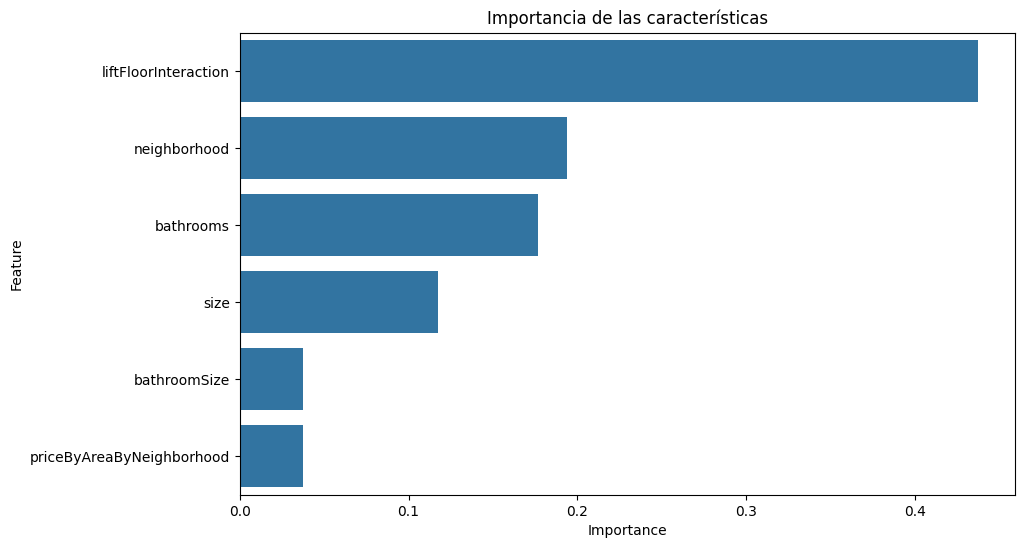

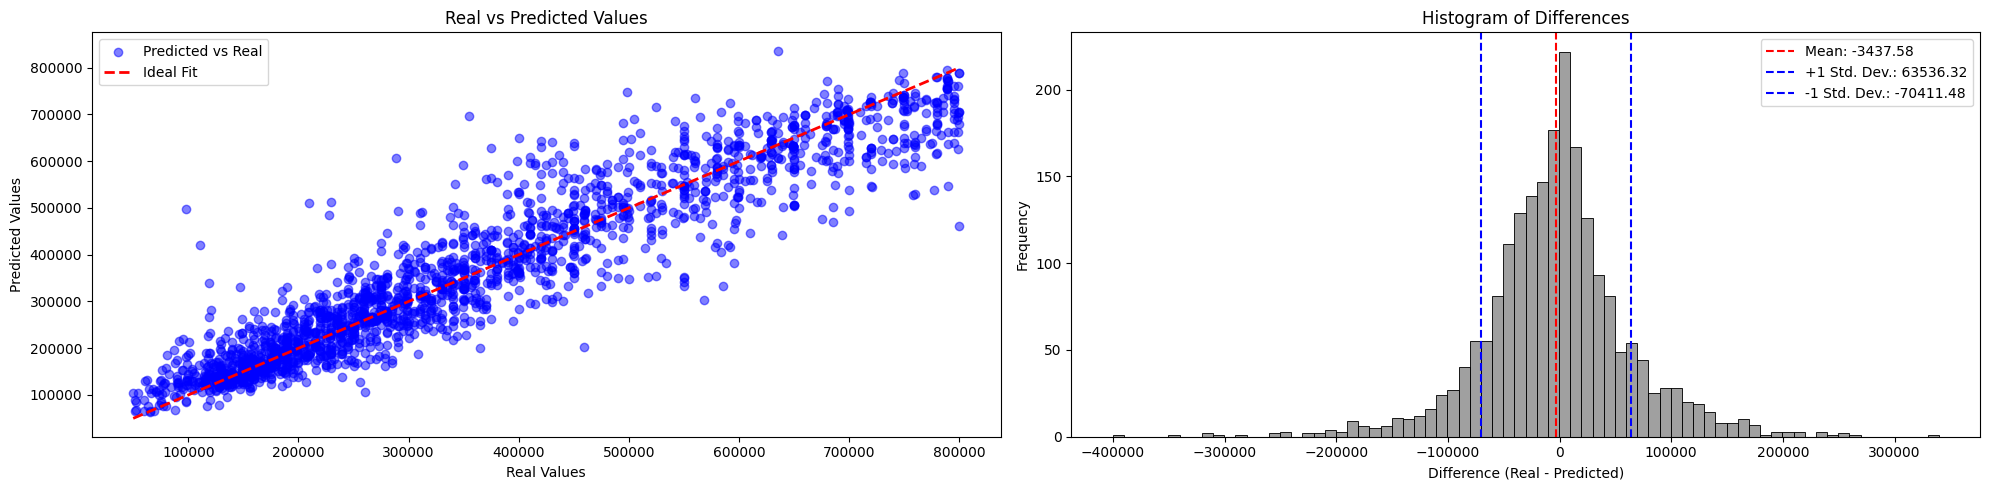

Best parameters found:  {'regressor__learning_rate': 0.1, 'regressor__max_depth': 5, 'regressor__n_estimators': 300}
RSME on test set:  67046.15874128722


In [132]:
# Supongamos que los datos están en un DataFrame llamado 'feature_engineering_df'
data = feature_engineering_df

# Seleccionar solo las columnas importantes
important_features = ['neighborhood', 'bathrooms', 'size','priceByAreaByNeighborhood','bathroomSize','liftFloorInteraction']
X = data[important_features]
y = data['price']

# Identificar columnas categóricas y numéricas
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

# Crear preprocesadores para columnas numéricas y categóricas
numeric_transformer = StandardScaler()
categorical_transformer = TargetEncoder()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Crear el pipeline con preprocesador y modelo de Gradient Boosting
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', GradientBoostingRegressor(random_state=42))])

# Dividir el conjunto de datos asegurando la estratificación por 'district'
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=data['district'], random_state=42)

# Definir los parámetros para la búsqueda
param_grid = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__learning_rate': [0.01, 0.1, 0.2],
    'regressor__max_depth': [3, 4, 5]
}

# Realizar GridSearchCV para optimizar hiperparámetros
grid_search = GridSearchCV(model, param_grid, cv=10, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Mejor modelo encontrado por GridSearchCV
best_model = grid_search.best_estimator_

# Evaluar el modelo en el conjunto de prueba
y_pred = best_model.predict(X_test)

# Calcular RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Importancia de las características
feature_importances = best_model.named_steps['regressor'].feature_importances_
importance_df = pd.DataFrame({'Feature': important_features, 'Importance': feature_importances}).sort_values(by='Importance', ascending=False)

# Gráfico de importancia de características
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Importancia de las características')
plt.show()

# Gráfico de diferencias entre valores predichos y reales
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.5, color='blue', label='Predicted vs Real')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Ideal Fit')
plt.xlabel('Real Values')
plt.ylabel('Predicted Values')
plt.title('Real vs Predicted Values')
plt.legend()

# Histograma de diferencias
differences = y_test - y_pred
plt.subplot(1, 2, 2)
sns.histplot(differences, kde=False, color='gray')
plt.axvline(differences.mean(), color='r', linestyle='--', label=f'Mean: {differences.mean():.2f}')
plt.axvline(differences.mean() + differences.std(), color='b', linestyle='--', label=f'+1 Std. Dev.: {differences.mean() + differences.std():.2f}')
plt.axvline(differences.mean() - differences.std(), color='b', linestyle='--', label=f'-1 Std. Dev.: {differences.mean() - differences.std():.2f}')
plt.xlabel('Difference (Real - Predicted)')
plt.ylabel('Frequency')
plt.title('Histogram of Differences')
plt.legend()

plt.tight_layout()
plt.show()

# Resultados
print("Best parameters found: ", grid_search.best_params_)
print("RSME on test set: ", rmse)



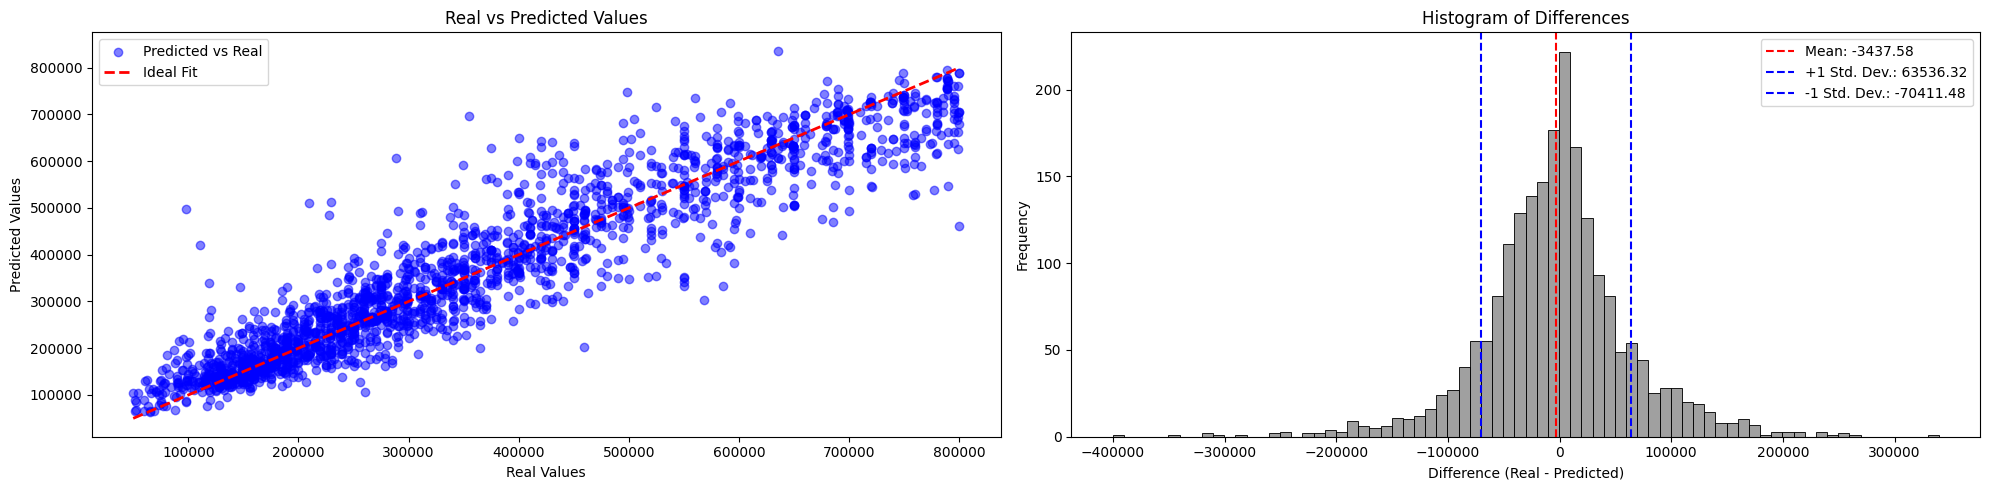

Best parameters found:  {'regressor__learning_rate': 0.1, 'regressor__max_depth': 5, 'regressor__n_estimators': 300}
RSME on test set:  67046.15874128722


In [133]:
# Supongamos que los datos están en un DataFrame llamado 'feature_engineering_df'
data = feature_engineering_df

# Seleccionar solo las columnas importantes
important_features = ['neighborhood', 'bathrooms', 'size','priceByAreaByNeighborhood','bathroomSize','liftFloorInteraction']
X = data[important_features]
y = data['price']

# Identificar columnas categóricas y numéricas
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

# Crear preprocesadores para columnas numéricas y categóricas
numeric_transformer = StandardScaler()
categorical_transformer = TargetEncoder()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Crear el pipeline con preprocesador y modelo de Gradient Boosting
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', GradientBoostingRegressor(random_state=42))])

# Dividir el conjunto de datos asegurando la estratificación por 'district'
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=data['district'], random_state=42)

# Definir los parámetros para la búsqueda
param_grid = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__learning_rate': [0.01, 0.1, 0.2],
    'regressor__max_depth': [3, 4, 5]
}

# Realizar GridSearchCV para optimizar hiperparámetros
grid_search = GridSearchCV(model, param_grid, cv=10, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Mejor modelo encontrado por GridSearchCV
best_model = grid_search.best_estimator_

# Evaluar el modelo en el conjunto de prueba
y_pred = best_model.predict(X_test)

# Calcular RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))



# Gráfico de diferencias entre valores predichos y reales
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.5, color='blue', label='Predicted vs Real')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Ideal Fit')
plt.xlabel('Real Values')
plt.ylabel('Predicted Values')
plt.title('Real vs Predicted Values')
plt.legend()

# Histograma de diferencias
differences = y_test - y_pred
plt.subplot(1, 2, 2)
sns.histplot(differences, kde=False, color='gray')
plt.axvline(differences.mean(), color='r', linestyle='--', label=f'Mean: {differences.mean():.2f}')
plt.axvline(differences.mean() + differences.std(), color='b', linestyle='--', label=f'+1 Std. Dev.: {differences.mean() + differences.std():.2f}')
plt.axvline(differences.mean() - differences.std(), color='b', linestyle='--', label=f'-1 Std. Dev.: {differences.mean() - differences.std():.2f}')
plt.xlabel('Difference (Real - Predicted)')
plt.ylabel('Frequency')
plt.title('Histogram of Differences')
plt.legend()

plt.tight_layout()
plt.show()

# Resultados
print("Best parameters found: ", grid_search.best_params_)
print("RSME on test set: ", rmse)


In [136]:
61782/feature_engineering_df['price'].mean()

0.16963103395998297

In [137]:
7551.61/feature_engineering_df['price'].mean()

0.02073399068276435